In [1]:
import torch
import torch.nn as nn
#from torch.optim.lr_scheduler import CosineAnnealingLR
from matplotlib import pyplot as plt
import numpy as np
from time import time
import os

In [2]:
print('torch version:', torch.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device:', device)

torch version: 1.13.1
device: cuda


In [3]:
TRAIN_DOM_POINTS = 4096 #8192 # 4096 8192 16384 32768 65536
TRAIN_BC_POINTS  = 2

#VALID_DOM_POINTS = 65536
#VALID_BC_POINTS  = 256

#DOM_NEW_POINTS = 128
#BC_NEW_POINTS  = 16

In [4]:
LEARNING_RATE = 0.001
STOP_CRITERIA = 0.0001 # 0.0005
EPOCHS        = 10000
GAMMA         = 4000

In [5]:
class Model(nn.Module):
    def __init__(self) -> None:
        super(Model,self).__init__()
        self.layer01 = torch.nn.Linear(1,20)
        self.layer02 = torch.nn.Linear(20,50)
        self.layer03 = torch.nn.Linear(50,50)
        self.layer04 = torch.nn.Linear(50,50)
        self.layer05 = torch.nn.Linear(50,20)
        self.layer06 = torch.nn.Linear(20,1)
    
    def forward(self,x):
        inputs      = x #torch.cat([x], axis=1)
        out_layer01 = torch.tanh(self.layer01(inputs))
        out_layer02 = torch.tanh(self.layer02(out_layer01))
        out_layer03 = torch.tanh(self.layer03(out_layer02))
        out_layer04 = torch.tanh(self.layer04(out_layer03))
        out_layer05 = torch.tanh(self.layer05(out_layer04))
        out_layer06 = self.layer06(out_layer05)
        output      = out_layer06
        return output


$$- \Delta u = f \quad x \text{ in }(0,1)$$
$$u(0)=u(1)= 0.$$

In [6]:
def f(x):
    return ((2*torch.pi)**2)*torch.sin(2*torch.pi*x)
#
def pde_residual(x):
    # model
    u = model(x)
    # Derivatives
    u_x  = torch.autograd.grad(u, x, create_graph=True, grad_outputs=torch.ones_like(u))[0]
    u_xx = torch.autograd.grad(u_x, x, create_graph=True, grad_outputs=torch.ones_like(u_x))[0]
    # residual
    residual = u_xx + f(x)
    return residual
#
def pde_BC(x_bc):
    # model
    u_bc = model(x_bc)
    # residual
    residual_bc = (u_bc - 0.)
    return residual_bc

In [7]:
def random_domain_points( n=8192, L = 1.):
    x = L*torch.rand(n, 1, device=device, requires_grad=True)
    return x
def random_BC_points(L = 1.):
    x_bc = torch.tensor([[0.],[L]], device=device, requires_grad=True)
    return x_bc

$\hat u(x) =nn(x;\theta)$ $\hat u(x) =x(x-1)nn(x;\theta)$ 

In [8]:
torch.manual_seed(42)
model = Model().to(device)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5000, eta_min=0.0001, last_epoch=-1)

In [10]:
x    = random_domain_points(n=TRAIN_DOM_POINTS)
x_bc = random_BC_points()

In [11]:
loss_dom_list  = []
loss_bc_list   = []

$$J(\theta) = \int_{0}^{1} \Delta \hat u(x;\theta) + f(x) + \gamma[(\hat u(0;\theta) - 0)^2) + (\hat u(1;\theta) - 0)^2] $$

In [12]:
t0 = time()
for epoch in range(EPOCHS):
    optimizer.zero_grad() # to make the gradients zero
    # RESIDUAL ################################################################ 
    residual   = pde_residual(x)
    residual_x = torch.autograd.grad(residual, x, 
                                     create_graph=True, 
                                     grad_outputs=torch.ones_like(residual)
                                    )[0]
    loss_dom = torch.mean(residual**2)
    # BC ######################################################################
    residual_bc = pde_BC(x_bc)
    loss_bc  =  torch.mean(residual_bc**2)
    # LOSS ####################################################################
    loss = loss_dom + GAMMA*loss_bc
    # Calculate and append individual losses to their respective lists
    loss_dom_list.append(loss_dom.item())
    loss_bc_list.append(loss_bc.item())
    # This is for computing gradients using backward propagation
    loss.backward(retain_graph=True) 
    optimizer.step() # 
    #scheduler.step()  # Update learning rate
    if epoch % 1000 == 0:
        print(f"Epoch: {epoch} - Loss: {loss.item():>1.6e}")#" - Learning Rate: {scheduler.get_last_lr()[0]:>1.6e}")
    if loss.item() < STOP_CRITERIA:
        torch.save(model.state_dict(), 'best_trained_model_gpu_spherical')
        break
#
print('computing time',(time() - t0)/60,'[min]')  

Epoch: 0 - Loss: 8.376445e+02
Epoch: 1000 - Loss: 7.190325e-01
Epoch: 2000 - Loss: 3.264043e-02
Epoch: 3000 - Loss: 5.232654e-02
Epoch: 4000 - Loss: 5.301641e-02
Epoch: 5000 - Loss: 1.366667e-01
Epoch: 6000 - Loss: 1.693960e-02
Epoch: 7000 - Loss: 1.305305e-02
Epoch: 8000 - Loss: 4.779836e-01
Epoch: 9000 - Loss: 2.455087e-02
computing time 3.768764396508535 [min]


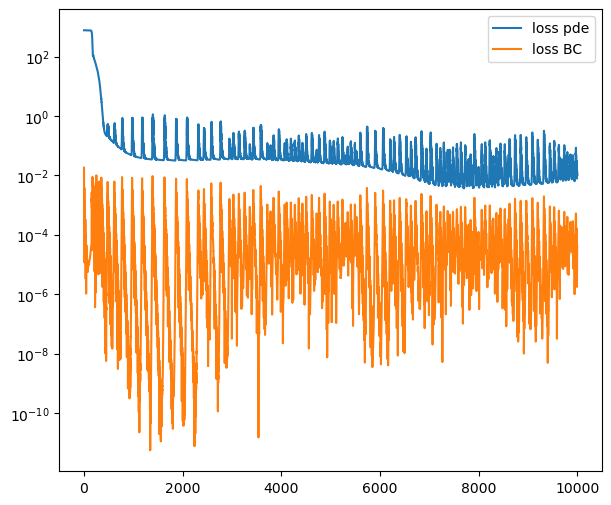

In [18]:
fig = plt.figure(figsize=(7,6))
plt.semilogy(loss_dom_list,label='loss pde')
plt.semilogy(loss_bc_list, label='loss BC')
plt.legend()

In [14]:
def exact_sol(x):
    return torch.sin(2*torch.pi*x)

In [24]:
x_vector  = torch.linspace(0.,1.,256,device=device).view(-1,1)
u_vector  = exact_sol(x_vector)
nn_vector = model(x_vector)
#
L2_error = torch.sqrt(torch.mean((u_vector - nn_vector)**2))

L2-error: 0.003432415658608079


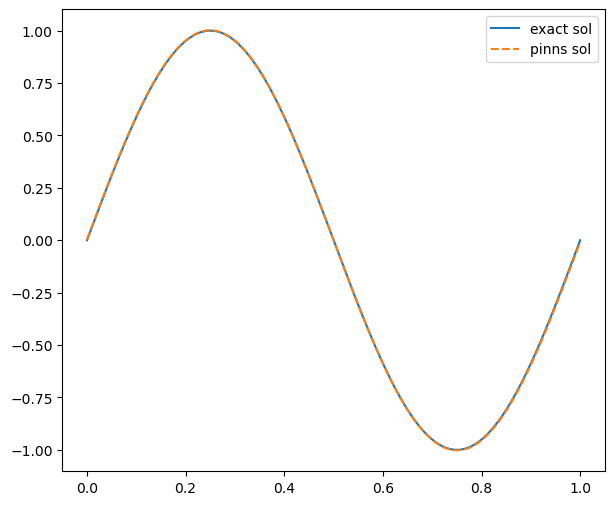

In [29]:
fig = plt.figure(figsize=(7,6))
plt.plot(x_vector.cpu(),u_vector.cpu(),label='exact sol')
plt.plot(x_vector.cpu(),nn_vector.cpu().detach().numpy(),label='pinns sol',
         linestyle='--'
        )
plt.legend()
print('L2-error:',L2_error.item())